# Creating a graph of related artists

In [2]:
import pandas as pd
import numpy as np
import pickle

from utils.SpotifyAPICommunicator import SpotifyAPICommunicator
from collections import defaultdict
from queue import Queue

## Collecting the data
We gather all artists that appeared in the 2019 Spotify charts

In [3]:
artists_2020 = pd.read_csv('../data/artist_info_2020-01-01__2021-01-01.csv')
artists_2020.head()

,artist,genres,popularity,followers,artist_id
0,Tones And I,"['australian pop', 'pop']",77,2886914,2NjfBq1NflQcKSeiDooVjY
1,Arizona Zervas,"['pop rap', 'rhode island rap']",72,643706,0vRvGUQVUjytro0xpb26bs
2,KAROL G,"['latin', 'reggaeton', 'reggaeton colombiano',...",87,20081766,790FomKkXshlbRYZFtlgla
3,Post Malone,"['dfw rap', 'melodic rap', 'rap']",91,35044259,246dkjvS1zLTtiykXe5h60
4,Maroon 5,"['pop', 'pop rock']",88,34099468,04gDigrS5kc9YWfZHwBETP


### Fetching related artists

In [117]:
client_id = 'id'
client_secret = 'secret'
spotify_api_communicator = SpotifyAPICommunicator(client_id, client_secret)
sp = spotify_api_communicator.get_sp()

artist_ids = artists_2020['artist_id']

# We already have the data for a chunk of artists (those who appeared in the top 200)
# We need to set apart the artists we haven't encountered before to fetch their data
artists_with_data = set(artist_id for index, artist_id in artist_ids.items())

# Store the links between artists
artist_links = defaultdict(set)

# We want to gather the related artists for a maximum of 5k artists (to reduce calls to the Spotify API)
artist_queue_limit = 5000
artist_count = len(artist_ids)
artist_queue = Queue()
for index, artist_id in artist_ids.items():
    artist_queue.put(artist_id)

related_artist_info = pd.DataFrame()
while not artist_queue.empty():
    artist_id = artist_queue.get()
    related_artists = sp.artist_related_artists(artist_id)['artists']
    for related_artist in related_artists:
        artist_links[artist_id].add(related_artist['id'])

        if related_artist['id'] not in artists_with_data:
            tmp = {'artist': related_artist['name'],
                   'genres': related_artist['genres'], 'popularity': related_artist['popularity'],
                   'followers': related_artist['followers']['total'], 'artist_id': related_artist['id']
                   }
            related_artist_info = related_artist_info.append(tmp, ignore_index=True)
            artists_with_data.add(related_artist['id'])
            if artist_count <= artist_queue_limit:
                artist_queue.put(related_artist['id'])
            artist_count += 1

related_artist_info['followers'] = related_artist_info['followers'].astype(int)
related_artist_info['popularity'] = related_artist_info['popularity'].astype(int)
related_artist_info.to_csv('../data/related_artist_info_2020.csv', index=False)

artist_links_file = open("../data/artist_links.pickle", "wb")
pickle.dump(artist_links, artist_links_file)
artist_links_file.close()

print('Total number of artists: %d' % len(artists_with_data))

Total number of artists: 19701


In [4]:
artist_links_file = open("../data/artist_links.pickle", "rb")
artist_links = pickle.load(artist_links_file)
artist_links_file.close()

artists_2020 = pd.read_csv('../data/artist_info_2020-01-01__2021-01-01.csv')
additional_artists = pd.read_csv('../data/related_artist_info_2020.csv')
artists_2020 = artists_2020.append(additional_artists)

adjacency = np.zeros((artists_2020.shape[0], artists_2020.shape[0]))
idToIndexMap = {}

for index, row in artists_2020.iterrows():
    idToIndexMap[row['artist_id']] = index

for artist_id, related_artists in artist_links.items():
    artist_index = idToIndexMap[artist_id]
    for related_artist in related_artists:
        related_artist_index = idToIndexMap[related_artist]
        adjacency[artist_index, related_artist_index] = 1

adjacency.shape

(19701, 19701)

### Convert adjacency matrix to sparse matrix

In [5]:
import scipy.sparse as sparse

sparse_adj = sparse.csc_matrix(adjacency)
print('The adjacency matrix has %d non-zero elements, this is equivalent to the number of edges' % sparse_adj.nnz)

The adjacency matrix has 99685 non-zero elements, this is equivalent to the number of edges


### Since our graph is directed, the degree of a node is actually the sum of its *indegree* and  *outdegree*.

In [6]:
# Add indegree and outdegree
degrees = adjacency @ np.ones(adjacency.shape[0]) + np.ones(adjacency.shape[0]).T @ adjacency

print('Minimum degree %d' % min(degrees))
print('Maximum degree %d' % max(degrees))
print('Average degree: %f' % np.mean(degrees))
print('Std of degree: %f. This number is quite high!' % np.std(degrees))

Minimum degree 0
Maximum degree 115
Average degree: 10.119791
Std of degree: 15.260374. This number is quite high!


Text(0, 0.5, '#artists having degree = k')

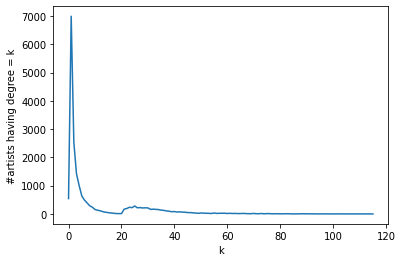

In [7]:
from itertools import groupby
import matplotlib.pyplot as plt


# Util function to return the distribution of values
def dist(values):
    values = sorted(values)

    # First make dist
    distribution = [(key, len(list(group))) for key, group in groupby(values)]

    return [x[0] for x in distribution], [x[1] for x in distribution]


degree_dist_x, degree_dist_y = dist(degrees)

plt.plot(degree_dist_x, degree_dist_y)
plt.xlabel("k")
plt.ylabel("#artists having degree = k")

The skewness towards small values makes the chart difficult to read. Let's use a log scale for the y axis.

Text(0, 0.5, 'log(#artists) having degree = k')

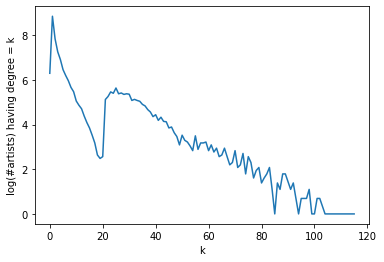

In [8]:
plt.plot(degree_dist_x, np.log(degree_dist_y))
plt.xlabel("k")
plt.ylabel("log(#artists) having degree = k")

Now, it's clearer that a non negligeable amount of artists have a relatively higher number of relations than the mean.

Text(0.5, 1.0, 'Cumulative distribution of degrees')

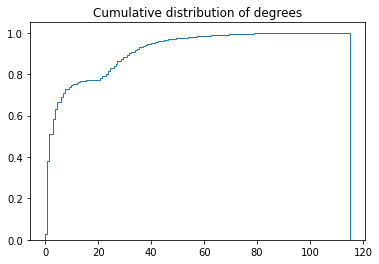

In [9]:
plt.hist(degrees, cumulative=True, density=True, bins='auto', histtype='step')
plt.title('Cumulative distribution of degrees')

According to the cumulative distribution, more than 20% of the artists have a number of related artists greater than 20.
Approximately 10% have more than 40 related artists.

### Global density of the graph

The density for a graph $G=(V,E)$ is $\delta(G) = \frac{2|E|}{|V|(|V|-1)}$. This corresponds to the number of edges divided to the number of possible edges with $|V|$ nodes.

In [10]:
density_adj = sparse_adj.nnz / (sparse_adj.shape[0] * (sparse_adj.shape[0] - 1))

print('The density is equal to %f' % density_adj)

The density is equal to 0.000257


As expected, the density is super low. This seems to be logical given that Spotify works with millions of artists, but also because we had to work with limited data (i.e. we can only fetch a limited number of artists).

By picking the artists that appeared in the top 200 charts, we are actually increasing our chances of finding the most "important" nodes in the graph of artists.

## PageRank
### Recommending a related artist based on our (extended) graph
Given that we now have a graph that relates artists together, we can try and use PageRank to give a user the top 10 artists that are most likely to please him, given a certain artist he or she likes.

In [43]:
import sknetwork as skn

pr = skn.ranking.PageRank()

# User is a big fan of drake
drake_row = artists_2020[artists_2020['artist'] == 'Drake']
drake_id = list(drake_row['artist_id'].items())[0][1]
drake_index = idToIndexMap[drake_id]

artist_names = list(artist['artist'] for index, artist in artists_2020.iterrows())
pr.fit(adjacency, seeds={drake_index: 1})

PageRank(damping_factor=0.85, solver='piteration', n_iter=10, tol=1e-06)

In [64]:
high_pr_artists = [{'name': artist_names[x], 'score': pr.scores_[x]} for x in np.argsort(pr.scores_)[-10:]]
print('Top 10 artists with highest PageRank score (with Drake as target):\n')
for v in high_pr_artists:
    print('%s - %f' % (v['name'], v['score']))

Top 10 artists with highest PageRank score:

Becky G - 0.006077
Irama - 0.006086
Gzuz - 0.006133
Peach Tree Rascals - 0.006133
Bobby "Boris" Pickett - 0.006313
Busta Rhymes - 0.006428
Jonas Brothers - 0.006501
CJ - 0.006556
Hayley Williams - 0.006587
Drake - 0.177542


We recognize some of the biggest names in the music industry. Most of the artists are Hip-Hop, Rap, and Pop artists, all genres in which Drake has excelled in over the years.

## Clustering to find communities

In [80]:
import scipy

louvain = skn.clustering.Louvain()
# Re-convert to sparse matrix to avoid bug
converted_matrix = scipy.sparse.csr_matrix(sparse_adj)
louvain.fit(converted_matrix)
louvain.labels_

array([ 41,   0,   0, ..., 231, 531, 603], dtype=int64)

In [81]:
print('The number of clusters is %d' % max(louvain.labels_))

The number of clusters is 603


Since we have a huge number of clusters, it might not be relevant to compare each and every one of them.
However, it may be interesting to have a look at the cluster that contain the most artists and see if we're able to recognize a certain pattern.

In [93]:
cluster_counts = defaultdict(int)

for i in louvain.labels_:
    cluster_counts[i] += 1

top_20_clusters = sorted(cluster_counts.items(), key=lambda x: x[1])[-20:]
top_20_clusters

[(19, 368),
 (18, 375),
 (17, 376),
 (16, 391),
 (15, 397),
 (13, 404),
 (14, 404),
 (12, 408),
 (11, 415),
 (10, 437),
 (9, 444),
 (8, 503),
 (7, 523),
 (6, 565),
 (5, 649),
 (4, 738),
 (3, 767),
 (2, 1097),
 (1, 1237),
 (0, 2252)]

We have found that a large chunk of clusters hold a great amount of artists (300+)!
We would like to check if these clusters are genre based. To do this we'll go over each cluster and get the top 3 genres represented.

In [146]:
from ast import literal_eval

def get_genres_from_artist_index(index):
    artist_row = artists_2020[artists_2020.index == index]
    genres = list(artist_row['genres'].items())
    if len(genres) == 0:
        return []
    genres = genres[0][1]
    return literal_eval(genres)

cluster_genres = [[] for i in range(20)]

for index, label in enumerate(louvain.labels_):
    if label > 19: continue
    cluster_genres[label].extend(get_genres_from_artist_index(index))

def get_top_3_genres(arr):
    genres_frequency_map = defaultdict(int)
    # Loop through all genres arrays and update dictionary
    for genre in arr:
        genres_frequency_map[genre] += 1

    # Sort genres by descending order of appearances
    sorted_genres_frequencies = sorted(genres_frequency_map.items(), key=lambda item: -item[1])

    total = len(arr)
    return [{'Genre': genre, 'Proportion': round(frequency / total, 2)} for genre, frequency in sorted_genres_frequencies[:3]]

def pretty_cluster_display(clabel, genres_dist):
    print('Cluster %d:' % clabel)
    for obj in genres_dist:
        print('\t⚫ %s (%f%%)' % (obj['Genre'], obj['Proportion'] * 100))
    print('\n')

for index, genres_array in enumerate(cluster_genres):
    # print('Cluster %d --> ' % index + str(get_top_3_genres(genres_array)))
    pretty_cluster_display(index, get_top_3_genres(genres_array))


Cluster 0:
	⚫ pop (4.000000%)
	⚫ underground hip hop (3.000000%)
	⚫ rap (3.000000%)


Cluster 1:
	⚫ adult standards (5.000000%)
	⚫ new wave pop (5.000000%)
	⚫ soft rock (4.000000%)


Cluster 2:
	⚫ pop dance (5.000000%)
	⚫ indie pop (4.000000%)
	⚫ edm (4.000000%)


Cluster 3:
	⚫ modern rock (5.000000%)
	⚫ stomp and holler (4.000000%)
	⚫ indie poptimism (4.000000%)


Cluster 4:
	⚫ classic rock (5.000000%)
	⚫ hard rock (5.000000%)
	⚫ rock (4.000000%)


Cluster 5:
	⚫ alternative metal (6.000000%)
	⚫ nu metal (5.000000%)
	⚫ pop punk (4.000000%)


Cluster 6:
	⚫ sertanejo pop (14.000000%)
	⚫ forro (9.000000%)
	⚫ sertanejo universitario (9.000000%)


Cluster 7:
	⚫ indie pop (5.000000%)
	⚫ otacore (3.000000%)
	⚫ dream smp (3.000000%)


Cluster 8:
	⚫ uk hip hop (11.000000%)
	⚫ house (6.000000%)
	⚫ uk drill (6.000000%)


Cluster 9:
	⚫ alternative r&b (11.000000%)
	⚫ chill r&b (11.000000%)
	⚫ indie r&b (10.000000%)


Cluster 10:
	⚫ traprun (11.000000%)
	⚫ gaming edm (10.000000%)
	⚫ alt z (9.000000

Although not all the clusters have definite genres, we can definitely spot niches:

Cluster 0: Trendy rap and hip hop songs
Cluster 4: Hardcore rock fans
Cluster 5: Metal heads
Cluster 6: Some kind of Portuguese Music
Cluster 8: UK hip hop and rap
Cluster 9: R & B
Cluster 10: Trap and Gaming Music
Cluster 11: Country Music
Cluster 12: Rap (gangster oriented)
Cluster 13: German hip hop and rap
Cluster 14: Italian pop and hip hop
Cluster 15: Spanish pop and hip hop
Cluster 16: Brazilian funk